In [6]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import seaborn as sns


In [3]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

In [7]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

# Filter rows where Iw is less than 1 
df_filtered = df[df["Iw"] < 1]

# Split into groups:
# For classification 'B'
df_B = df_filtered[df_filtered["Classification"] == "B"]

# For combined classification 'Wandering' (i.e. HSW and LSW)
wandering_types = ['HSW', 'LSW']
df_wandering = df_filtered[df_filtered["Classification"].isin(wandering_types)]

# --- For group 'B' ---
# Find the 5 lowest Iw values
lowest_values_B = df_B.nsmallest(5, "Iw")
# Find the 5 highest Iw values
highest_values_B = df_B.nlargest(5, "Iw")

print("Classification: B")
print("5 Rivers with the lowest Iw values, their Iw, and mean_ebi_site:")
for river, iw, ebi in zip(lowest_values_B["River"], lowest_values_B["Iw"], lowest_values_B["mean_ebi_site"]):
    print(f"{river}: Iw = {iw}, mean_ebi_site = {ebi}")

print("\n5 Rivers with the greatest Iw values (but still less than 1), their Iw, and mean_ebi_site:")
for river, iw, ebi in zip(highest_values_B["River"], highest_values_B["Iw"], highest_values_B["mean_ebi_site"]):
    print(f"{river}: Iw = {iw}, mean_ebi_site = {ebi}")

# --- For group 'Wandering' (HSW and LSW) ---
# Find the 5 lowest Iw values
lowest_values_wandering = df_wandering.nsmallest(5, "Iw")
# Find the 5 highest Iw values
highest_values_wandering = df_wandering.nlargest(5, "Iw")

print("\nClassification: Wandering (HSW and LSW)")
print("5 Rivers with the lowest Iw values, their Iw, and mean_ebi_site:")
for river, iw, ebi in zip(lowest_values_wandering["River"], lowest_values_wandering["Iw"], lowest_values_wandering["mean_ebi_site"]):
    print(f"{river}: Iw = {iw}, mean_ebi_site = {ebi}")

print("\n5 Rivers with the greatest Iw values (but still less than 1), their Iw, and mean_ebi_site:")
for river, iw, ebi in zip(highest_values_wandering["River"], highest_values_wandering["Iw"], highest_values_wandering["mean_ebi_site"]):
    print(f"{river}: Iw = {iw}, mean_ebi_site = {ebi}")



Classification: B
5 Rivers with the lowest Iw values, their Iw, and mean_ebi_site:
Bhareli_NTRoadCrossing: Iw = 0.1439215946668974, mean_ebi_site = 2.3125931501675794
Mbam_Goura: Iw = 0.1578726453050691, mean_ebi_site = 2.2577828864565164
Ob_Phominskoje: Iw = 0.1701018006717985, mean_ebi_site = 4.565619748858538
Taku_NearTulsequa: Iw = 0.1868757691119045, mean_ebi_site = 2.314220018261884
Brahmaputra_Yangcun: Iw = 0.3386885583821236, mean_ebi_site = 2.3130902314886552

5 Rivers with the greatest Iw values (but still less than 1), their Iw, and mean_ebi_site:
Amur_Khabarovsk: Iw = 0.9962258870218558, mean_ebi_site = 4.954453918012378
Lena_Tabaga: Iw = 0.991297323563511, mean_ebi_site = 4.953106061807975
SaptKosi_Chatara-Kothu: Iw = 0.6558818037260832, mean_ebi_site = 2.4839132885396342
Brahmaputra_Pasighat: Iw = 0.6519444711745275, mean_ebi_site = 6.234539430636733
Indus_Attock: Iw = 0.6493158805574453, mean_ebi_site = 3.4430925320347634

Classification: Wandering (HSW and LSW)
5 Rivers

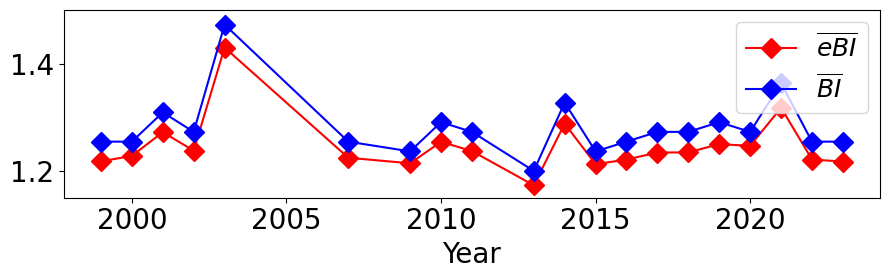

In [33]:
target_river = "Kamchatka_Kozyrevsk"
root_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
river_folder = os.path.join(root_dir, target_river)

# Define the path to the "rivgraph" folder within the target river folder
rivgraph_path = os.path.join(river_folder, "rivgraph")

# Define paths for the eBI and BI annual CSV files
ebi_csv = os.path.join(rivgraph_path, "eBI_results_annual.csv")
bi_csv = os.path.join(rivgraph_path, "BI_results_annual.csv")

# Read the annual data
ebi_df = pd.read_csv(ebi_csv)
bi_df = pd.read_csv(bi_csv)

# Merge the two DataFrames on "Year" and "Cross_section"
merged_df = pd.merge(ebi_df, bi_df, on=["Year", "Cross_section"], how="inner")

# Ensure Year is numeric and drop rows with missing years
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# ------------------------------
# Yearly average across all cross sections (Reach level)
# ------------------------------
yearly_avg = merged_df.groupby("Year").agg({"eBI": "mean", "BI": "mean"}).reset_index()

# ------------------------------
# Plotting configuration: Single Plot for Reach-Averaged Data
# ------------------------------
plt.figure(figsize=(9, 3))

# Set colors and marker properties
ebi_color = "red"
bi_color = "blue"
marker_style = "D"  
marker_size = 10

# Plot the yearly average for eBI and BI
plt.plot(yearly_avg["Year"], yearly_avg["eBI"], marker=marker_style, markersize=marker_size,
         color=ebi_color, linestyle='-', label=r'$\overline{\mathit{eBI}}$')
plt.plot(yearly_avg["Year"], yearly_avg["BI"], marker=marker_style, markersize=marker_size,
         color=bi_color, linestyle='-', label=r'$\overline{\mathit{BI}}$')

plt.xlabel("Year", fontsize=20)
#plt.ylabel("Reach-averaged", fontsize=20)
plt.legend(loc="upper right", fontsize=18)
plt.ylim(bottom=1.15, top=1.5)
plt.tick_params(axis='both', labelsize=20)
plt.grid(False)
plt.tight_layout()
plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\12_Kamchatka_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

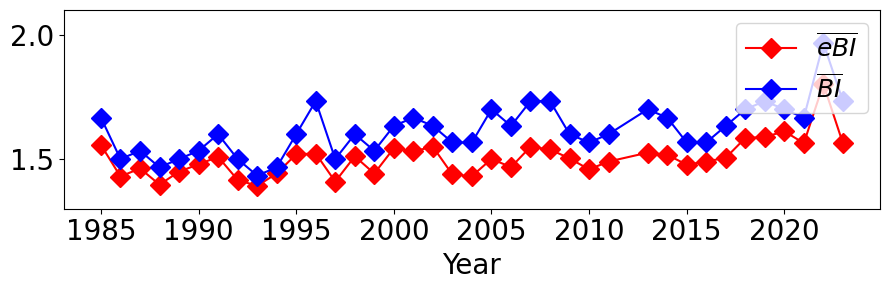

In [32]:
target_river = "Madeira_Humaita"
root_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
river_folder = os.path.join(root_dir, target_river)

# Define the path to the "rivgraph" folder within the target river folder
rivgraph_path = os.path.join(river_folder, "rivgraph")

# Define paths for the eBI and BI annual CSV files
ebi_csv = os.path.join(rivgraph_path, "eBI_results_annual.csv")
bi_csv = os.path.join(rivgraph_path, "BI_results_annual.csv")

# Read the annual data
ebi_df = pd.read_csv(ebi_csv)
bi_df = pd.read_csv(bi_csv)

# Merge the two DataFrames on "Year" and "Cross_section"
merged_df = pd.merge(ebi_df, bi_df, on=["Year", "Cross_section"], how="inner")

# Ensure Year is numeric and drop rows with missing years
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# ------------------------------
# Yearly average across all cross sections (Reach level)
# ------------------------------
yearly_avg = merged_df.groupby("Year").agg({"eBI": "mean", "BI": "mean"}).reset_index()

# ------------------------------
# Plotting configuration: Single Plot for Reach-Averaged Data
# ------------------------------
plt.figure(figsize=(9, 3))

# Set colors and marker properties
ebi_color = "red"
bi_color = "blue"
marker_style = "D"  
marker_size = 10

# Plot the yearly average for eBI and BI
plt.plot(yearly_avg["Year"], yearly_avg["eBI"], marker=marker_style, markersize=marker_size,
         color=ebi_color, linestyle='-', label=r'$\overline{\mathit{eBI}}$')
plt.plot(yearly_avg["Year"], yearly_avg["BI"], marker=marker_style, markersize=marker_size,
         color=bi_color, linestyle='-', label=r'$\overline{\mathit{BI}}$')

plt.xlabel("Year", fontsize=20)
plt.legend(loc="upper right", fontsize=18)
plt.ylim(bottom=1.3, top=2.1)
plt.tick_params(axis='both', labelsize=20)
plt.grid(False)


plt.tight_layout()
plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\12_Madeira_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

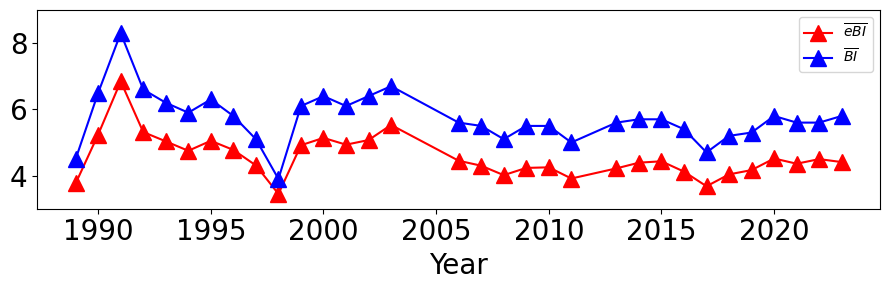

In [34]:
target_river = "Ob_Phominskoje"
root_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
river_folder = os.path.join(root_dir, target_river)

# Define the path to the "rivgraph" folder within the target river folder
rivgraph_path = os.path.join(river_folder, "rivgraph")

# Define paths for the eBI and BI annual CSV files
ebi_csv = os.path.join(rivgraph_path, "eBI_results_annual.csv")
bi_csv = os.path.join(rivgraph_path, "BI_results_annual.csv")

# Read the annual data
ebi_df = pd.read_csv(ebi_csv)
bi_df = pd.read_csv(bi_csv)

# Merge the two DataFrames on "Year" and "Cross_section"
merged_df = pd.merge(ebi_df, bi_df, on=["Year", "Cross_section"], how="inner")

# Ensure Year is numeric and drop rows with missing years
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# ------------------------------
# Yearly average across all cross sections (Reach level)
# ------------------------------
yearly_avg = merged_df.groupby("Year").agg({"eBI": "mean", "BI": "mean"}).reset_index()

# ------------------------------
# Plotting configuration: Single Plot for Reach-Averaged Data
# ------------------------------
plt.figure(figsize=(9, 3))

# Set colors and marker properties
ebi_color = "red"
bi_color = "blue"
marker_style = "^"  
marker_size = 12

# Plot the yearly average for eBI and BI
plt.plot(yearly_avg["Year"], yearly_avg["eBI"], marker=marker_style, markersize=marker_size,
         color=ebi_color, linestyle='-', label=r'$\overline{\mathit{eBI}}$')
plt.plot(yearly_avg["Year"], yearly_avg["BI"], marker=marker_style, markersize=marker_size,
         color=bi_color, linestyle='-', label=r'$\overline{\mathit{BI}}$')

plt.xlabel("Year", fontsize=20)
plt.legend(loc="upper right")
plt.ylim(bottom=3, top=9)
plt.tick_params(axis='both', labelsize=20)
plt.grid(False)
plt.tight_layout()
plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\12_Ob_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

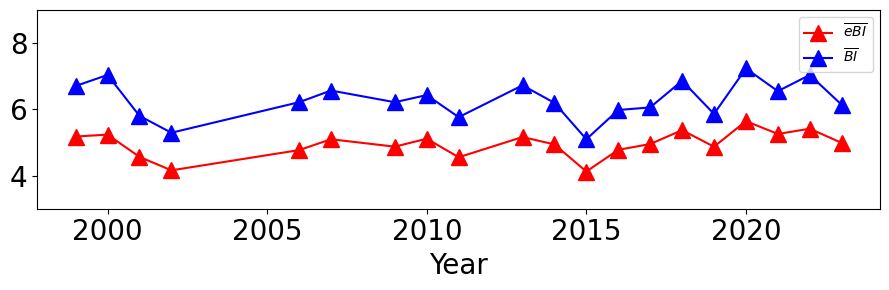

In [35]:
target_river = "Lena_Tabaga"
root_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
river_folder = os.path.join(root_dir, target_river)

# Define the path to the "rivgraph" folder within the target river folder
rivgraph_path = os.path.join(river_folder, "rivgraph")

# Define paths for the eBI and BI annual CSV files
ebi_csv = os.path.join(rivgraph_path, "eBI_results_annual.csv")
bi_csv = os.path.join(rivgraph_path, "BI_results_annual.csv")

# Read the annual data
ebi_df = pd.read_csv(ebi_csv)
bi_df = pd.read_csv(bi_csv)

# Merge the two DataFrames on "Year" and "Cross_section"
merged_df = pd.merge(ebi_df, bi_df, on=["Year", "Cross_section"], how="inner")

# Ensure Year is numeric and drop rows with missing years
merged_df["Year"] = pd.to_numeric(merged_df["Year"], errors="coerce")
merged_df = merged_df.dropna(subset=["Year"])
merged_df["Year"] = merged_df["Year"].astype(int)

# ------------------------------
# Yearly average across all cross sections (Reach level)
# ------------------------------
yearly_avg = merged_df.groupby("Year").agg({"eBI": "mean", "BI": "mean"}).reset_index()

# ------------------------------
# Plotting configuration: Single Plot for Reach-Averaged Data
# ------------------------------
plt.figure(figsize=(9, 3))

# Set colors and marker properties
ebi_color = "red"
bi_color = "blue"
marker_style = "^"  
marker_size = 12

# Plot the yearly average for eBI and BI
plt.plot(yearly_avg["Year"], yearly_avg["eBI"], marker=marker_style, markersize=marker_size,
         color=ebi_color, linestyle='-', label=r'$\overline{\mathit{eBI}}$')
plt.plot(yearly_avg["Year"], yearly_avg["BI"], marker=marker_style, markersize=marker_size,
         color=bi_color, linestyle='-', label=r'$\overline{\mathit{BI}}$')

plt.xlabel("Year", fontsize=20)
plt.legend(loc="upper right")
plt.ylim(bottom=3, top=9)
plt.tick_params(axis='both', labelsize=20)
plt.grid(False)
plt.tight_layout()
plt.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\12_Lena_intermittency.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)